In [ ]:
import sys
print(sys.executable)

In [ ]:
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
from pathlib import Path
from tqdm import tqdm
import json, re

from helpers.filtering import looks_like_ar_ma_latn_pure, remove_invisible_chars

In [ ]:
nltk.download("punkt_tab")

out_file = Path("ar_ma_latin_data.jsonl")

In [ ]:
print("Loading Darija Latin Wikipedia dataset...")
dataset = load_dataset("UBC-NLP/nilechat-arabizi-mor", split="train", streaming=True)

In [ ]:
import json
from tqdm import tqdm
import re

min_words = 3  # min words per example (we also re-check in helper)
n_sentences = 0
n_examples = 0
n_words = 0

TARGET_SENTENCES = 30_000   # or any number you like

with out_file.open("w", encoding="utf-8") as f_out:
    for example in tqdm(dataset, desc="Processing Darija Arabizi (pure latin)"):

        if n_sentences >= TARGET_SENTENCES:
            break

        # Adapt this to your dataset schema: "text", "arabizi", "transcription", etc.
        text = example["text"]
        if not text:
            continue

        sentences = re.split(r'(?<=[\.؟\?!])\s+', text)

        for sent in sentences:

            if n_sentences >= TARGET_SENTENCES:
                break

            # Treat each split chunk as one "sentence"
            sent = sent.strip()
            if not sent:
                continue

            # Clean invisible chars & normalize inner whitespace
            sent = remove_invisible_chars(sent)
            sent = re.sub(r"\s+", " ", sent)

            if not sent:
                continue

            # Basic length filter
            word_count = len(sent.split())
            if word_count < min_words:
                continue

            # Pure-latin Arabizi filter
            if not looks_like_ar_ma_latn_pure(sent):
                continue

            # Normalize: lowercase, keep digits
            sent = sent.lower().replace("\n", " ")

            line = json.dumps({"text": sent}, ensure_ascii=False)
            f_out.write(line + "\n")

            n_words += word_count
            n_sentences += 1
            n_examples += 1

print(f"Done. Saved {n_examples} examples, {n_words} words, and {n_sentences} sentences to: {out_file}")


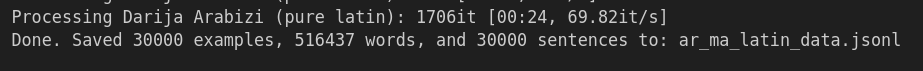
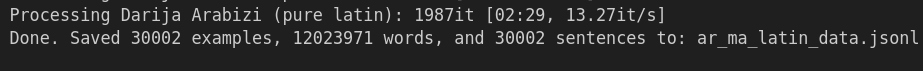
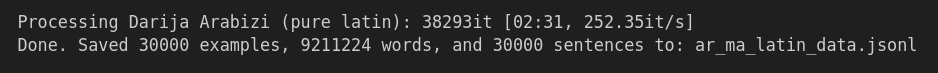

In [ ]:
from pathlib import Path
import random

input_path = Path("ar_ma_latin_data.jsonl")        # your big file
out_dir = Path("../../MAFT/ar_ma_latin")

train_path = out_dir / "train.jsonl"
val_path   = out_dir / "validation.jsonl"
test_path  = out_dir / "test.jsonl"

# ratios: change them if you want
train_ratio = 0.8
val_ratio   = 0.1
test_ratio  = 0.1

random.seed(42)  # for reproducibility

n_train = n_val = n_test = 0

with input_path.open("r", encoding="utf-8") as fin, \
     train_path.open("w", encoding="utf-8") as f_train, \
     val_path.open("w", encoding="utf-8") as f_val, \
     test_path.open("w", encoding="utf-8") as f_test:

    for line in fin:
        line = line.strip()
        if not line:
            continue

        r = random.random()
        if r < train_ratio:
            f_train.write(line + "\n")
            n_train += 1

        elif r < train_ratio + val_ratio:
            f_val.write(line + "\n")
            n_val += 1

        else:
            f_test.write(line + "\n")
            n_test += 1

print("Done.")
print("train:", n_train)
print("validation:", n_val)
print("test:", n_test)



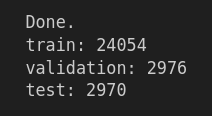